# Introduction

In this kernel, we attempt to improve the [Gaussian naive Bayes classifier](https://www.kaggle.com/blackblitz/gaussian-naive-bayes) by replacing the Gaussian model with the more flexible Gaussian mixture model.

We implement the Gaussian mixture naive Bayes model to predict Santander Customer Transaction Prediction data. The problem has a binary target and 200 continuous features, and we assume that these features are conditionally independent given the class. We model the target $Y$ as Bernoulli, taking values $0$ (negative) and $1$ (positive). The features $X_0,X_1,\ldots,X_{199}$ are modelled as continuous random variables. Recall the Bayes rule:

$$p_{Y|X_0,X_1,\ldots,X_{199}}(y|x_0,x_1,\ldots,x_{199})=\frac{p_Y(y)\prod_{i=0}^{199}f_{X_i|Y}(x_i|y)}{\sum_{y'=0}^1p_Y(y')\prod_{i=0}^{199}f_{X_i|Y}(x_i|y')}$$

The prior $p_Y(y)$ will be taken as the proportion of the two classes, and the likelihood $f_{X_i|Y}(x_i|y)$ will be obtained by fitting the data with the Gaussian mixture model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (20, 10)
title_config = {'fontsize': 20, 'y': 1.05}

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
X_train = train.iloc[:, 2:].values.astype('float64')
y_train = train['target'].values
X_test = test.iloc[:, 1:].values.astype('float64')

# Getting Acquainted with the Gaussian Mixture Model
The Gaussian mixture model gives a mixture of normal distrubutions. We can use [sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to fit the data and compare it with the histogram to get a feel of its behaviour. We also need to standardize the features because too narrow data can impair the fitting ability of the Gaussian mixture model. There are two important hyperparameters: `n_components` is the number of normal distributions to mix in and `reg_covar` is a regularization parameter that controls the spread of the bumps. Note that `score_samples` method gives the log density, so we need to exponentiate to get the density.

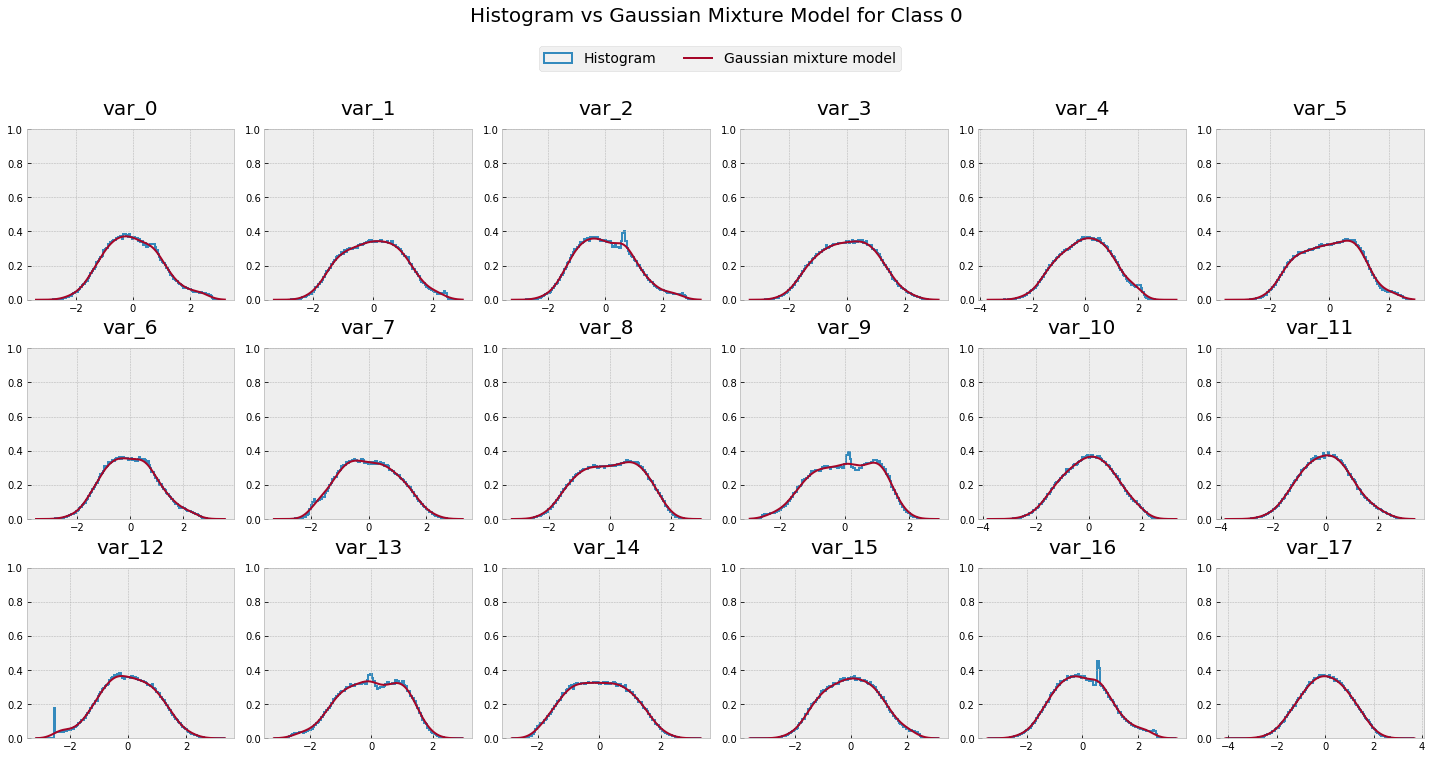

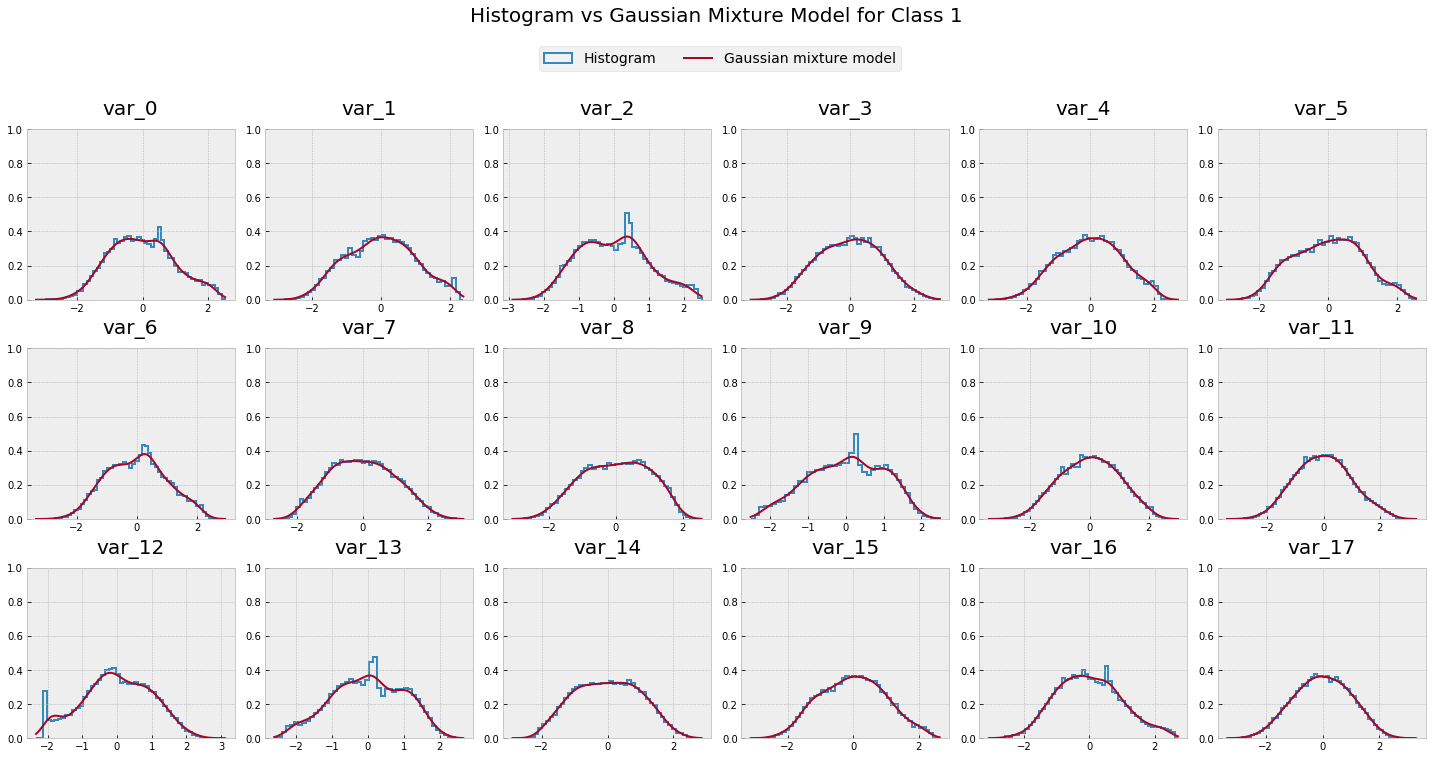

In [5]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

for i in range(2):
    fig, axes = plt.subplots(3, 6)
    axes = axes.ravel()
    for j in range(len(axes)):
        feature = StandardScaler().fit_transform(X_train[y_train == i, j:j + 1])
        hist = axes[j].hist(feature, bins='auto', histtype='step',
                            linewidth=2, density=True)
        grid = np.linspace(feature.min(), feature.max(), num=1000)
        log_density = (GaussianMixture(n_components=10, reg_covar=0.03)
                       .fit(feature).score_samples(grid[:, None]))
        gmm = axes[j].plot(grid, np.exp(log_density))
        axes[j].set_title(f'var_{j}', **title_config)
        axes[j].set_ylim([0, 1])
    fig.suptitle(f'Histogram vs Gaussian Mixture Model for Class {i}',
                 **title_config)
    fig.legend((hist[2][0], gmm[0]), ('Histogram', 'Gaussian mixture model'),
               loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

# Implementing the Model

We are going to use the Gaussian mixture model to estimate the likelihood probability density functions $f_{X_i|Y}(x_i|y)$. Since multiplying a lot of small numbers will lead to underflow, we take the logarithm and turn products into sums:
$$\ln p_{Y|X_0,X_1,\ldots,X_{199}}(y|x_0,x_1,\ldots,x_{199})=\underbrace{\overbrace{\ln p_Y(y)}^\text{log prior}+\overbrace{\sum_{i=0}^{199}\ln f_{X_i|Y}(x_i|y)}^\text{log likelihood}}_\text{log joint}-\overbrace{\ln\sum_{y'=0}^1e^{\ln p_Y(y')+\sum_{i=0}^{199}\ln f_{X_i|Y}(x_i|y')}}^\text{log marginal}$$

Key points in the implementation are:
* The log prior is set as the logarithm of the proportion of different classes.
* The log likelihood is computed by using [sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)'s `score_samples` method.
* Computing the log marginal is prone to overflow/underflow, so we use [scipy.special.logsumexp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html) to avoid that.
* In the end, we convert back to probability by exponentiation.

All the heavy lifting is done by the Gaussian mixture model. The rest of the computation is very simple and fast.

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp

class GaussianMixtureNB(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, reg_covar=1e-06):
        self.n_components = n_components
        self.reg_covar = reg_covar
    def fit(self, X, y):
        self.log_prior_ = np.log(np.bincount(y) / len(y))
        # shape of self.log_pdf_
        shape = (len(self.log_prior_), X.shape[1])
        self.log_pdf_ = [[GaussianMixture(n_components=self.n_components,
                                          reg_covar=self.reg_covar)
                          .fit(X[y == i, j:j + 1])
                          .score_samples for j in range(shape[1])]
                         for i in range(shape[0])]
    def predict_proba(self, X):
        # shape of log_likelihood before summing
        shape = (len(self.log_prior_), X.shape[1], X.shape[0])
        log_likelihood = np.sum([[self.log_pdf_[i][j](X[:, j:j + 1])
                                  for j in range(shape[1])]
                                 for i in range(shape[0])], axis=1).T
        log_joint = self.log_prior_ + log_likelihood
        return np.exp(log_joint - logsumexp(log_joint, axis=1, keepdims=True))
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

# Training and Evaluating the Model

We train and evaluate the model by using the training AUC and validation AUC. The process can take time because we train the Gaussian mixture model 400 times, and the training time will increase with higher `n_components`. In order to speed up the hyperparameter search, we use validation, which is k times faster than k-fold cross-validation. Feel free to use cross-validation if you have the time (and tell me if you find better hyperparameters).

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

i_train, i_valid = next(StratifiedShuffleSplit(n_splits=1).split(X_train, y_train))

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

pipeline = make_pipeline(StandardScaler(),
                         GaussianMixtureNB(n_components=10, reg_covar=0.03))
pipeline.fit(X_train[i_train], y_train[i_train])
print('Training AUC is {}.'
      .format(roc_auc_score(y_train[i_train],
                            pipeline.predict_proba(X_train[i_train])[:, 1])))
print('Validation AUC is {}.'
      .format(roc_auc_score(y_train[i_valid],
                            pipeline.predict_proba(X_train[i_valid])[:, 1])))

Training AUC is 0.9079950354678008.
Validation AUC is 0.8977096175597831.


# Submitting the Test Predictions

We retrain using all the data and submit the test predictions for the competition.

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gaussianmixturenb', GaussianMixtureNB(n_components=10, reg_covar=0.03))])

In [10]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = pipeline.predict_proba(X_test)[:, 1]
submission.to_csv('submission.csv', index=False)

# Conclusion

The Gaussian mixture naive Bayes performs very well and is an improvement over the Gaussian naive Bayes, although it takes a little more time to train. It has the advantage that it is more flexible and does not require that the data come from a normal distribution. The only assumption is that the features are conditionally independent given the class. An alternative approach is to use kernel density estimation. Whichever method we use, the goal is to have a model that is simple (easily understood), tractable (easily computed) and accurate (represents reality very well).